In [154]:
print('Initializing data engineering!')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json, requests, gzip

Initializing data engineering!


### Brazil data engineering

In [194]:
url = 'https://data.brasil.io/dataset/covid19/caso.csv.gz'
response = requests.get(url)
# response.content
with open('/home/rafael/tmp/caso.csv.gz', 'wb') as f:
    f.write(response.content)
    
with gzip.open('/home/rafael/tmp/caso.csv.gz') as f:
    df = pd.read_csv(f)

In [195]:
df.rename(columns={'confirmed': 'cases', 'estimated_population_2019':'population', 'order_for_place':'day'}, inplace= True)
df['date'] = df['date'].astype('datetime64[ns]')

df = df[(df['city']!='Importados/Indefinidos')]

#apenas cidades de SP e por estados
# df = df[((df['state']=='SP') & (df['place_type']=='city')) | (df['place_type']=='state')  ]
df = df[(df['place_type']=='state')  ]

df.population.fillna(0, inplace=True)
df.city_ibge_code.fillna(0, inplace=True)

df.population = df.population.astype('int')
df.city_ibge_code = df.city_ibge_code.astype('int')

df.drop(columns=['confirmed_per_100k_inhabitants'], inplace=True)
df.fillna('-', inplace=True)

df.sort_values(['state','city','date'], inplace = True)
df.reset_index(inplace = True, drop=True)


df['week'] = df.date.dt.isocalendar().week 
df['year'] = df.date.dt.year
df['yearMonth'] = df.date.map(lambda x: x.strftime('%Y-%m'))

df.tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,city_ibge_code,death_rate,week,year,yearMonth
8211,2021-01-09,TO,-,state,93099,1270,298,False,1572866,1590248.0,17,0.0136,1,2021,2021-01
8212,2021-01-10,TO,-,state,93261,1274,299,False,1572866,1590248.0,17,0.0137,1,2021,2021-01
8213,2021-01-11,TO,-,state,93895,1278,300,False,1572866,1590248.0,17,0.0136,2,2021,2021-01
8214,2021-01-12,TO,-,state,94381,1286,301,False,1572866,1590248.0,17,0.0136,2,2021,2021-01
8215,2021-01-13,TO,-,state,94945,1294,302,True,1572866,1590248.0,17,0.0136,2,2021,2021-01


#### Feature engineering - por semana

In [196]:
print('Iniciando feature engieering Brasil')
inicio = datetime.datetime.now()

states = df.state.unique()
# states = ['SP']
df.drop(df[df['cases'] == 0 ].index, axis=0, inplace= True)

df['perc_death'] = (df['deaths']/df['cases'] * 100).round(2)
df.rename(columns={'order_for_place': 'day'}, inplace= True)

for state in states:
    cities = df[df['state']==state].city.unique()
#     cities = ['Santa Gertrudes']
#     print(datetime.datetime.now().time(), state)
    for city in cities:
        indexes = (df['state']==state) & (df.city == city)
        # valores diários
        df.loc[indexes, 'case_day'] = df[indexes]['cases'].diff()    
        df.loc[indexes, 'death_day'] = df[indexes]['deaths'].diff()

        # Igualo o valor da primeira linha igual ao primeiro número do acumulado, pois se o acumulado começa em 1 o primeiro diff fica igual a 0
        df.loc[(indexes) & (df.day == 1), 'case_day']= df.loc[(indexes) & (df.day==1), 'cases']
        df.loc[(indexes) & (df.day == 1), 'death_day']= df.loc[(indexes) & (df.day==1), 'deaths']

#         % daily variations
        df.loc[indexes, 'var_case_day'] = ((df[indexes]['case_day'].diff())) #/ df[indexes]['case_day'].shift()*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(2)
        df.loc[indexes, 'var_death_day'] = ((df[indexes]['death_day'].diff())) #/ df[indexes]['death_day'].shift()*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(2)

        # Buscando a população do estado/cidade e calculado os indicador per milhar
        if not df[indexes].population.empty:
            thousand = df[indexes]['population'] / 1000
            cases_thousand = (df[indexes]['cases'] / thousand)
            deaths_thousand = (df[indexes]['deaths'] / thousand)
            case_day_thousand = (df[indexes]['case_day'] / thousand)
            death_day_thousand = (df[indexes]['death_day'] / thousand)
        else:
            cases_thousand = 0
            deaths_thousand = 0
            case_day_thousand = 0
            death_day_thousand = 0
            
        df.loc[indexes, 'cases_thousand'] = cases_thousand
        df.loc[indexes, 'deaths_thousand'] = deaths_thousand
        df.loc[indexes, 'case_day_thousand'] = case_day_thousand
        df.loc[indexes, 'death_day_thousand'] = death_day_thousand


df.fillna(0, inplace=True)

df['case_day'] = df['case_day'].astype('int')
df['death_day'] = df['death_day'].astype('int')


df['cases_thousand'] = df['cases_thousand'].round(3)
df['deaths_thousand'] = df['deaths_thousand'].round(3)
df['case_day_thousand'] = df['case_day_thousand'].round(3)
df['death_day_thousand'] = df['death_day_thousand'].round(3)


df['cases'] = df['case_day']
df['deaths'] = df['death_day']


termino = datetime.datetime.now()
print('finalizado em ', termino-inicio)
df[indexes].tail()

Iniciando feature engieering Brasil
finalizado em  0:00:00.407187


,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,...,yearMonth,perc_death,case_day,death_day,var_case_day,var_death_day,cases_thousand,deaths_thousand,case_day_thousand,death_day_thousand
8211,2021-01-09,TO,-,state,93099,1270,298,False,1572866,1590248.0,...,2021-01,1.36,183,3,-287.0,-1.0,59.191,0.807,0.116,0.002
8212,2021-01-10,TO,-,state,93261,1274,299,False,1572866,1590248.0,...,2021-01,1.37,162,4,-21.0,1.0,59.294,0.810,0.103,0.003
8213,2021-01-11,TO,-,state,93895,1278,300,False,1572866,1590248.0,...,2021-01,1.36,634,4,472.0,0.0,59.697,0.813,0.403,0.003
8214,2021-01-12,TO,-,state,94381,1286,301,False,1572866,1590248.0,...,2021-01,1.36,486,8,-148.0,4.0,60.006,0.818,0.309,0.005
8215,2021-01-13,TO,-,state,94945,1294,302,True,1572866,1590248.0,...,2021-01,1.36,564,8,78.0,0.0,60.364,0.823,0.359,0.005


In [197]:
# df2 =  df.groupby(['state','city','yearMonth'], sort=True).agg({
df2 =  df.groupby(['yearMonth'], sort=True).agg({
#          'cases':'sum', 
         'deaths': 'sum',
         'case_day':'mean',
         'death_day': 'mean',
         'var_case_day': 'mean',
         'var_death_day':'mean',
         'case_day_thousand':'mean',
         'death_day_thousand':'mean',
         'cases_thousand':'mean',
         'deaths_thousand':'mean',
})

df2.tail()

,cases,deaths,case_day,death_day,var_case_day,var_death_day,case_day_thousand,death_day_thousand,cases_thousand,deaths_thousand
yearMonth,,,,,,,,,,
2020-09,132059175,4002712,1118.384139,27.690211,-21.467162,0.273854,0.176589,0.003463,28.787599,0.679919
2020-10,160143379,4709105,868.996381,19.310012,-19.168878,-0.572979,0.134593,0.002402,33.415193,0.770082
2020-11,171820155,4814648,1009.036386,16.682560,8.387704,-0.052698,0.159944,0.002066,37.424119,0.831797
2020-12,216893377,5656980,1605.595923,26.143885,36.899281,0.797362,0.231423,0.003325,43.832946,0.913996
2021-01,111071125,2797871,1746.198925,32.725806,38.518817,0.346774,0.245911,0.004151,48.651091,0.995476


In [198]:
# df.to_csv('../data/brazil_states_corona19_data.csv', index = True)

In [199]:
df2['mean']= df2.death_day.expanding().mean()
df2.tail()

,cases,deaths,case_day,death_day,var_case_day,var_death_day,case_day_thousand,death_day_thousand,cases_thousand,deaths_thousand,mean
yearMonth,,,,,,,,,,,
2020-09,132059175,4002712,1118.384139,27.690211,-21.467162,0.273854,0.176589,0.003463,28.787599,0.679919,21.935661
2020-10,160143379,4709105,868.996381,19.310012,-19.168878,-0.572979,0.134593,0.002402,33.415193,0.770082,21.643922
2020-11,171820155,4814648,1009.036386,16.682560,8.387704,-0.052698,0.159944,0.002066,37.424119,0.831797,21.147786
2020-12,216893377,5656980,1605.595923,26.143885,36.899281,0.797362,0.231423,0.003325,43.832946,0.913996,21.601977
2021-01,111071125,2797871,1746.198925,32.725806,38.518817,0.346774,0.245911,0.004151,48.651091,0.995476,22.528962


In [200]:
# df[df['country']=='Belgium']
print('Data engineering done!')

Data engineering done!


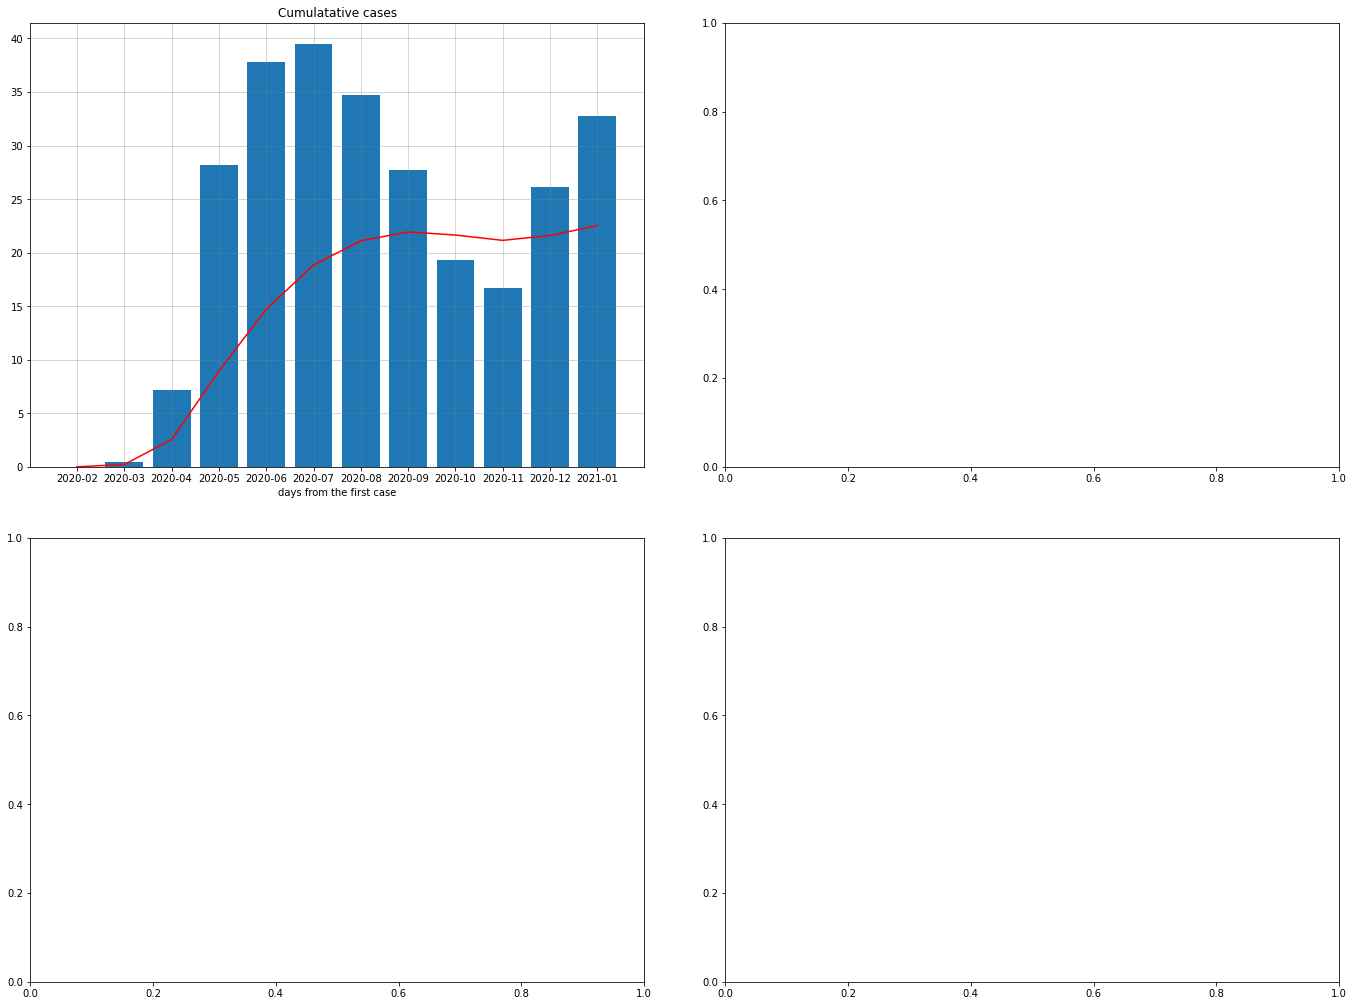

In [201]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)


# ax2.set_title("Daily cases - moving average (last 7 days)")
# ax2.set_xlabel("days from the first case")
# ax2.grid(color='gray', alpha = 0.4)

# ax3.set_title("Cumulative deaths")
# ax3.set_xlabel("days from the first case")
# ax3.grid(color='gray', alpha = 0.4)

# ax4.set_title("Daily deaths - moving average (last 7 days)")
# ax4.set_xlabel("days from the first case")
# ax4.grid(color='gray', alpha = 0.4)

# ax5.set_title("Cumulative recoveries")
# ax5.set_xlabel("days from the first case")
# ax5.grid(color='gray', alpha = 0.4)

# ax6.set_title("Recoveries - moving average (last 7 days)")
# ax6.set_xlabel("days from the first case")
# ax6.grid(color='gray', alpha = 0.4)


ax1.bar(df2.index, df2.death_day )
ax1.plot(df2.index, df2['mean'], color='red')

# ax2.plot(dados.day, dados.avg7_cases, label = state)
# ax3.plot(dados.day, dados.deaths, label = state)
# ax4.plot(dados.day, dados.avg7_deaths, label = state)
#     ax5.plot(df[indexes].day, df[indexes].recoveries, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries, label = state)

# ax1.legend()
# ax2.legend()
# ax3.legend()
# ax4.legend()
# ax5.legend()
# ax6.legend()
# fig.savefig('../analysis/brazilian_states_cases_deaths.png')